In [65]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
import pickle
import obspy
from scipy.signal import find_peaks
import os
import pandas as pd

import cmcrameri.cm as cmc

from matplotlib import patches


In [66]:
combined = pd.read_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/combined.csv')

In [1]:
def moment_in_different_windows(window = None, window_prop = None):
    if window is None and window_prop is None:
        window_prop = 1

    diff = []
    moments = []

    romb = []
    simpson = []
    trapz = []

    simpson_short = []

    durations = []

    for scardec_name in os.listdir('/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec'):
        db = combined[combined['scardec_name']==scardec_name]

        time_opt = []
        momentrate_opt = []

        time_moy = []
        momentrate_moy = []

        event = os.listdir(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}')
        starts = [n for n, l in enumerate(event) if l.startswith('fctopt')]
        with open(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}/{event[starts[0]]}') as f:
            lines = f.read().splitlines()

        lines = lines[2:]
        for line in lines:
            split = line.split(' ')
            split = [s for s in split if s not in ['', ' ', '\n']]
            time_opt.append(float(split[0]))
            momentrate_opt.append(float(split[1]))

        momentrate_opt = np.array(momentrate_opt)

        not_zero = np.where(momentrate_opt > 0)[0]

        start = min(not_zero)
        end = max(not_zero)
        duration = time_opt[end] - time_opt[start]
        durations.append(duration)

        simpson.append(scipy.integrate.simpson(momentrate_opt[start:end], dx = time_opt[1]-time_opt[0]))
        trapz.append(scipy.integrate.trapezoid(momentrate_opt, dx = time_opt[1]-time_opt[0]))
        moments.append(db['moment'].values[0])

        if window_prop is None: #using static time window
            end_window = int((end-start)*(window/duration))
        else: #based on proportion of duration
            end_window = int((end-start)*window_prop)

        simpson_short.append(scipy.integrate.simpson(momentrate_opt[start:start + end_window], dx = time_opt[1]-time_opt[0]))
    return moments, simpson, simpson_short, trapz, durations

In [68]:
def moment_in_different_windows_moy(window = None, window_prop = None):
    if window is None and window_prop is None:
        window_prop = 1

    diff = []
    moments = []

    romb = []
    simpson = []
    trapz = []

    simpson_short = []

    durations = []

    for scardec_name in os.listdir('/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec'):
        db = combined[combined['scardec_name']==scardec_name]

        time_opt = []
        momentrate_opt = []

        time_moy = []
        momentrate_moy = []

        event = os.listdir(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}')
        starts = [n for n, l in enumerate(event) if l.startswith('fctmoy')]
        with open(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}/{event[starts[0]]}') as f:
            lines = f.read().splitlines()

        lines = lines[2:]
        for line in lines:
            split = line.split(' ')
            split = [s for s in split if s not in ['', ' ', '\n']]
            time_moy.append(float(split[0]))
            momentrate_moy.append(float(split[1]))

        momentrate_moy = np.array(momentrate_moy)

        not_zero = np.where(momentrate_moy > 0)[0]

        start = min(not_zero)
        end = max(not_zero)
        duration = time_moy[end] - time_moy[start]
        durations.append(duration)

        simpson.append(scipy.integrate.simpson(momentrate_moy[start:end], dx = time_moy[1]-time_moy[0]))
        trapz.append(scipy.integrate.trapz(momentrate_moy, dx = time_moy[1]-time_moy[0]))
        moments.append(db['moment'].values[0])

        if window_prop is None: #using static time window
            end_window = int((end-start)*(window/duration))
        else: #based on proportion of duration
            end_window = int((end-start)*window_prop)

        simpson_short.append(scipy.integrate.simpson(momentrate_moy[start:start + end_window], dx = time_moy[1]-time_moy[0]))
    return moments, simpson, simpson_short, trapz, durations

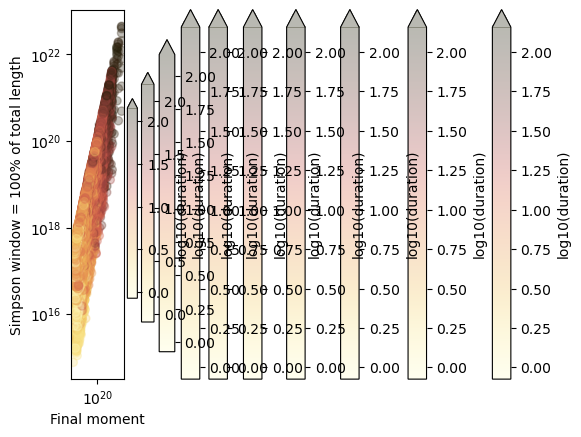

In [69]:
for window_prop in np.arange(0.1, 1.1, 0.1):
    moments, simpson, simpson_short, trapz, durations = moment_in_different_windows(window_prop = window_prop)
    durations = np.array(durations)
    plt.scatter(moments, simpson_short, c = np.log10(durations), cmap = cmc.lajolla, alpha = 0.3)#, vmax=60)
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel(f'Simpson window = {window_prop * 100:.0f}% of total length')
    plt.xlabel('Final moment')
    plt.colorbar(extend='max', label='log10(duration)')
    plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/integrating_in_window/window_prop_{window_prop:.1f}_shaded_by_duration.png')
    #plt.show()

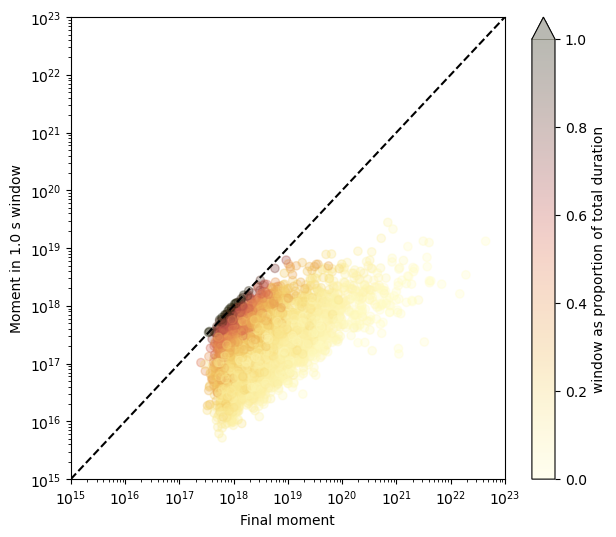

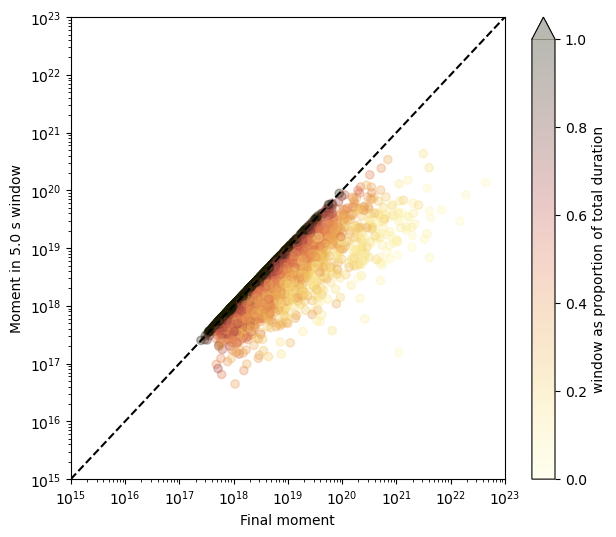

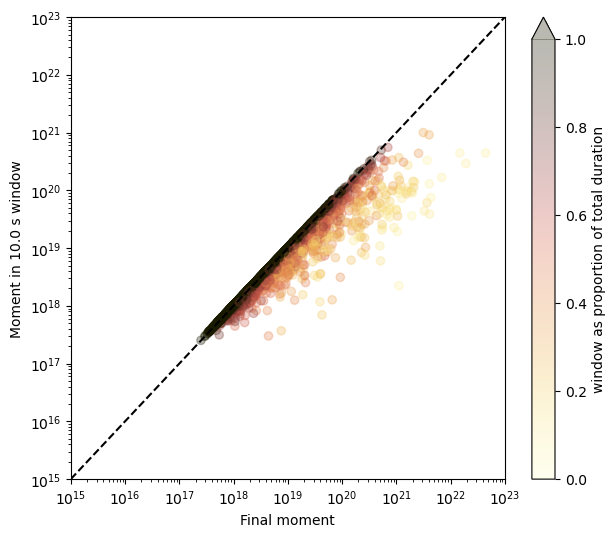

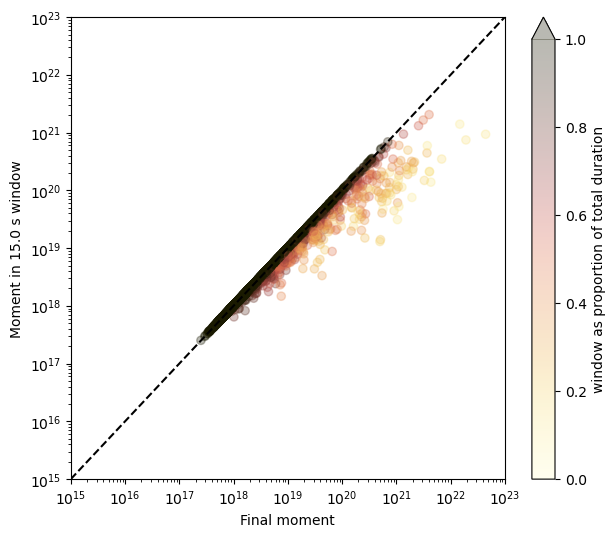

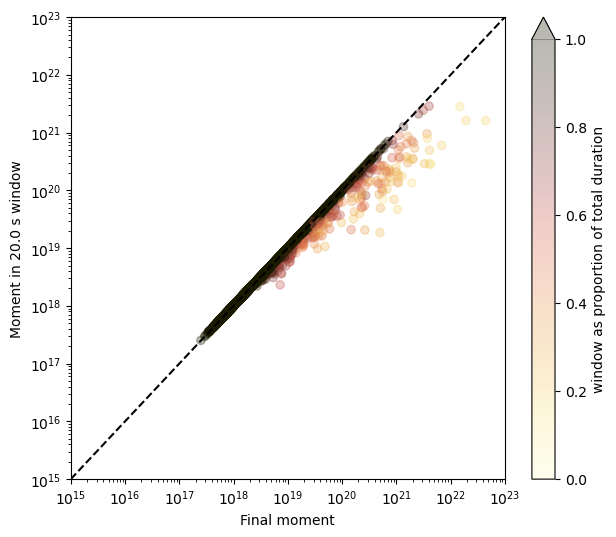

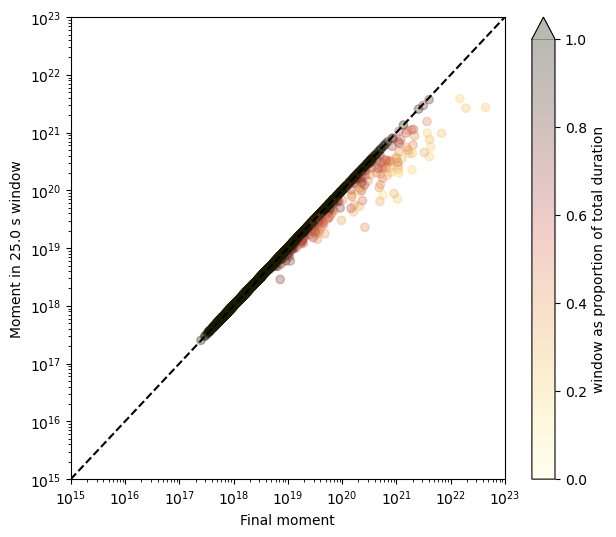

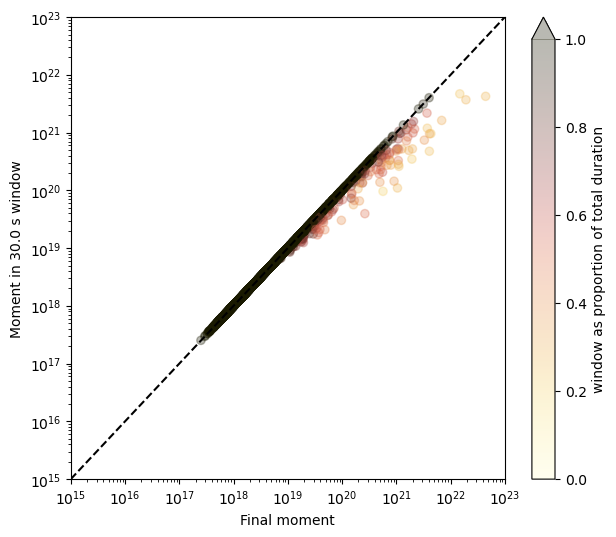

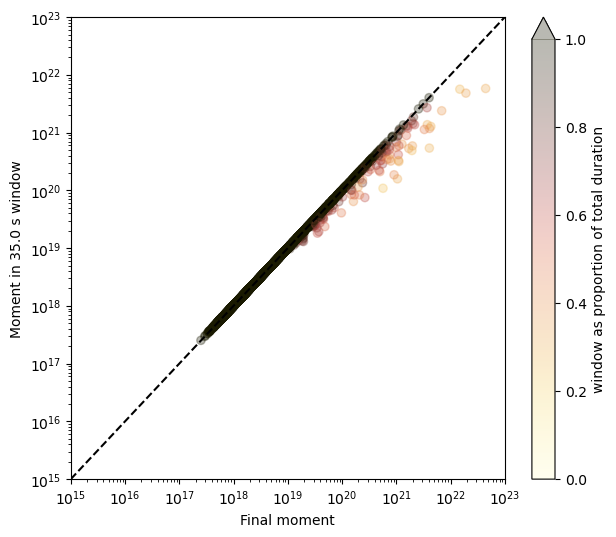

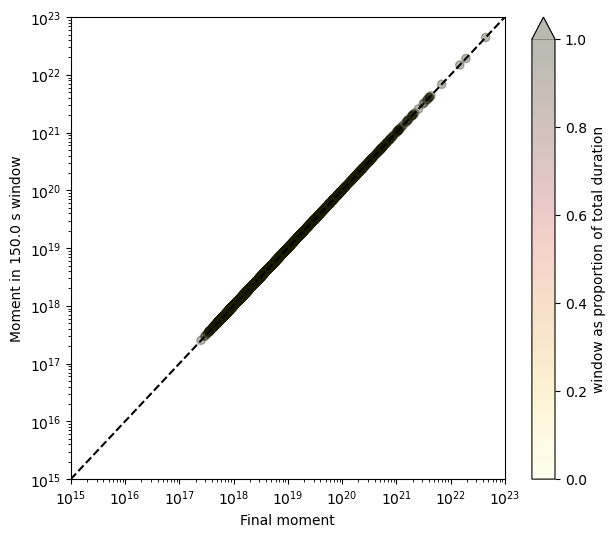

In [70]:
for window in [1, 5, 10, 15, 20, 25, 30, 35, 150]: # np.arange(1, 30, 5):
    moments, simpson, simpson_short, trapz, durations = moment_in_different_windows(window = window, window_prop = None)
    durations = np.array(durations)

    fig, ax = plt.subplots(figsize=(7, 6))
    plt.scatter(simpson, simpson_short, c = window/durations, cmap = cmc.lajolla, vmax = 1, vmin = 0, alpha = 0.3)
    plt.plot([1e15, 1e23], [1e15, 1e23], color = 'black', linestyle = '--')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel(f'Moment in {window:.1f} s window')
    plt.xlabel('Final moment')

    plt.colorbar(extend='max', label='window as proportion of total duration')
    plt.ylim([1e15, 1e23])
    plt.xlim([1e15, 1e23])



    #plt.legend()

    plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/integrating_in_window/window_{window:.0f}s_shaded_by_proportion.png')
    plt.show()

0.1


/tmp/ipykernel_226045/3982052024.py:12: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(np.log10(moments), np.log10(simpson_short), color = cmc.lajolla(window_prop), alpha = 0.1)#, vmax=60)


0.4
0.7000000000000001
1.0000000000000002


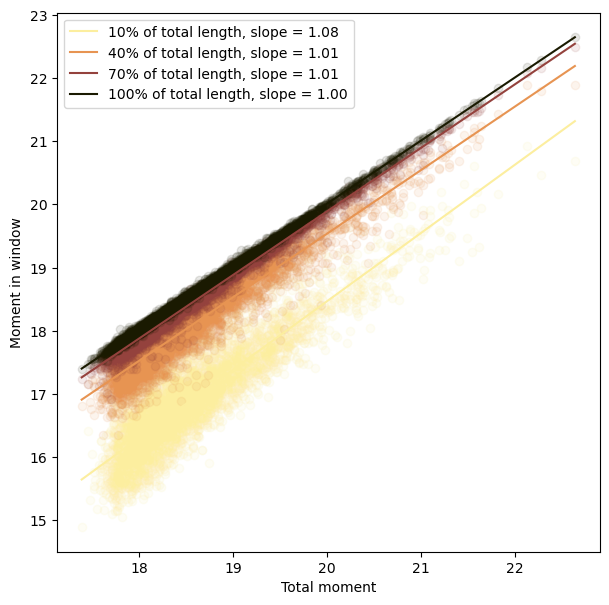

In [71]:
interval = 0.3

fig, ax = plt.subplots(figsize=(7, 7))

for window_prop in np.arange(0.1, 1.1, interval):
    print(window_prop)
    moments, simpson, simpson_short, trapz, durations = moment_in_different_windows(window_prop = window_prop)
    durations = np.array(durations)
    moments = np.array(moments)
    simpson_short = np.array(simpson_short)

    ax.scatter(np.log10(moments), np.log10(simpson_short), color = cmc.lajolla(window_prop), alpha = 0.1)#, vmax=60)

    not_zero = np.where(simpson_short > 0)[0]

    result = scipy.stats.linregress(np.log10(moments[not_zero]), np.log10(simpson_short[not_zero]))

    x_plot = np.log10(np.logspace(np.log10(min(moments)), np.log10(max(moments))))

    ax.plot(x_plot, result.intercept + x_plot*result.slope,
            label = f'{window_prop * 100:.0f}% of total length, slope = {result.slope:.2f}',
            alpha = 1,
            color = cmc.lajolla(window_prop))

    # plt.xscale('log')
    # plt.yscale('log')

plt.ylabel('Moment in window')
plt.xlabel('Total moment')

plt.legend()
fig.show()

fig.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/integrating_in_window/linregress_best_fit_for_diff_proportions_every_{interval}_with_data_.png')

1
6
11
16
21
26


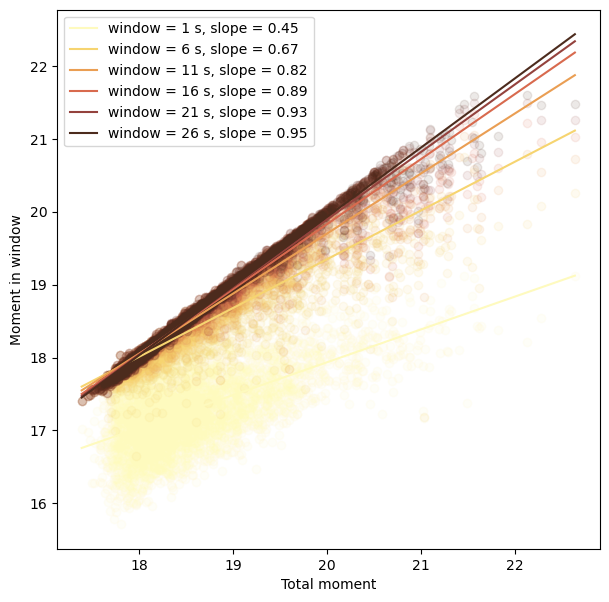

In [72]:
interval = 5
max_window = 30
min_window = 1
fig, ax = plt.subplots(figsize=(7, 7))


for window in np.arange(min_window, max_window, interval):
    print(window)
    moments, simpson, simpson_short, trapz, durations = moment_in_different_windows(window = window)
    durations = np.array(durations)
    moments = np.array(moments)
    simpson_short = np.array(simpson_short)

    ax.scatter(np.log10(moments), np.log10(simpson_short), color = cmc.lajolla(window/max_window), alpha = 0.1)#, vmax=60)

    not_zero = np.where(simpson_short > 0)[0]
    result = scipy.stats.linregress(np.log10(moments[not_zero]), np.log10(simpson_short[not_zero]))

    x_plot = np.log10(np.logspace(np.log10(min(moments)), np.log10(max(moments))))

    ax.plot(x_plot, result.intercept + x_plot*result.slope,
            label = f'window = {window:.0f} s, slope = {result.slope:.2f}',
            alpha = 1,
            color = cmc.lajolla(window/max_window))

    # plt.xscale('log')
    # plt.yscale('log')

plt.ylabel('Moment in window')
plt.xlabel('Total moment')

plt.legend()
fig.show()

fig.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/integrating_in_window/linregress_best_fit_for_diff_windows_min_{min_window}_max_{max_window}_interval_{interval}.png')

0.1


/tmp/ipykernel_226045/3470324738.py:19: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(np.log10(simpson), np.log10(simpson_short), label = 'opt', alpha = 0.1, marker = '.')#, color = cmc.lajolla(window_prop), alpha = 0.1)#, vmax=60)
/tmp/ipykernel_226045/3470324738.py:31: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(np.log10(simpson_moy), np.log10(simpson_short_moy), label = 'moy', alpha = 0.1, marker = '.')#, color = cmc.lajolla(window_prop), alpha = 0.1)#, vmax


0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9
1.0


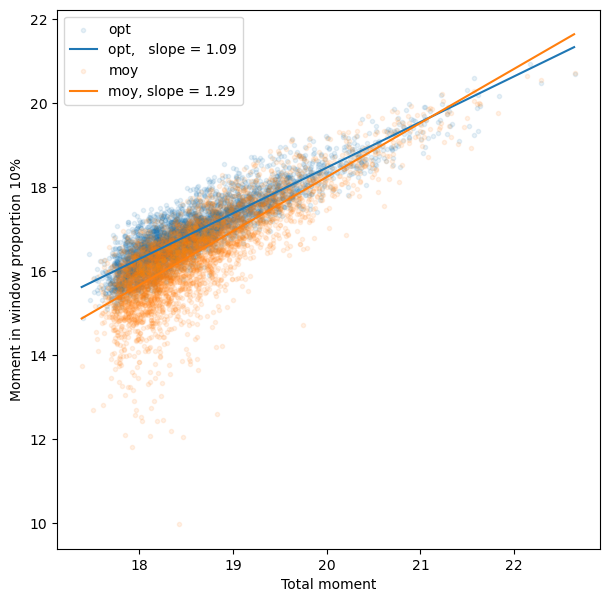

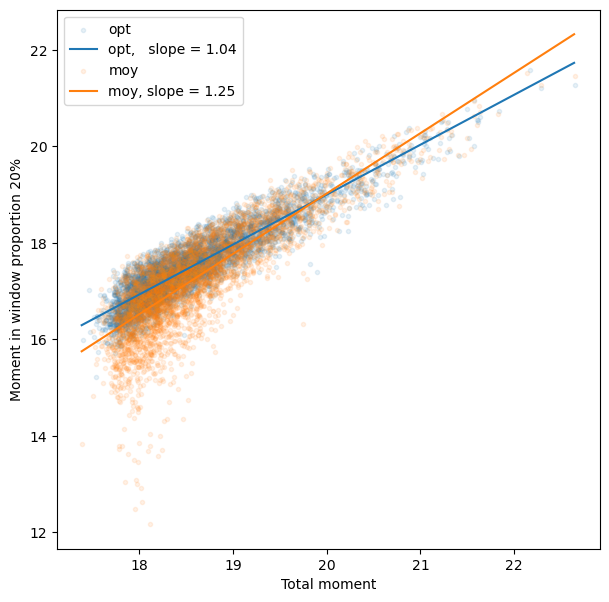

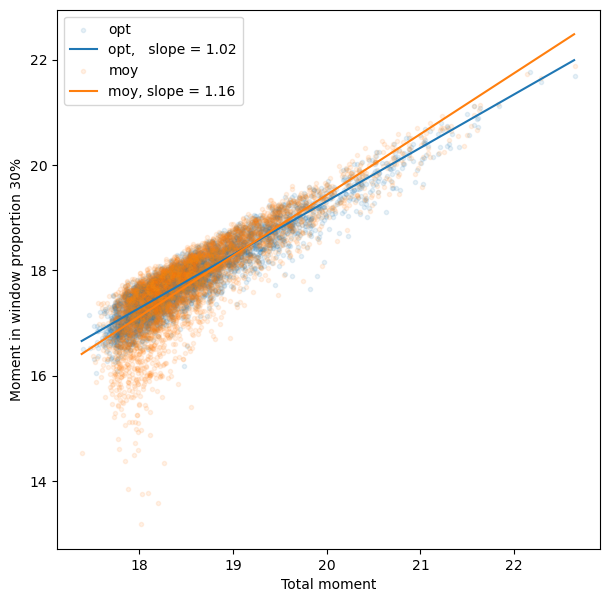

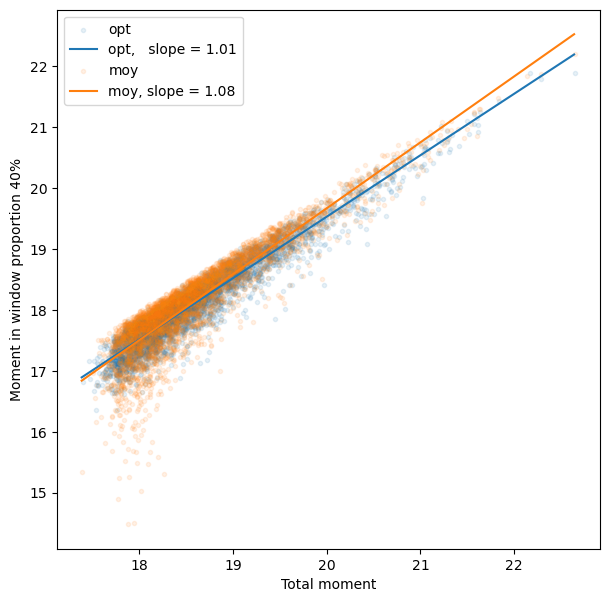

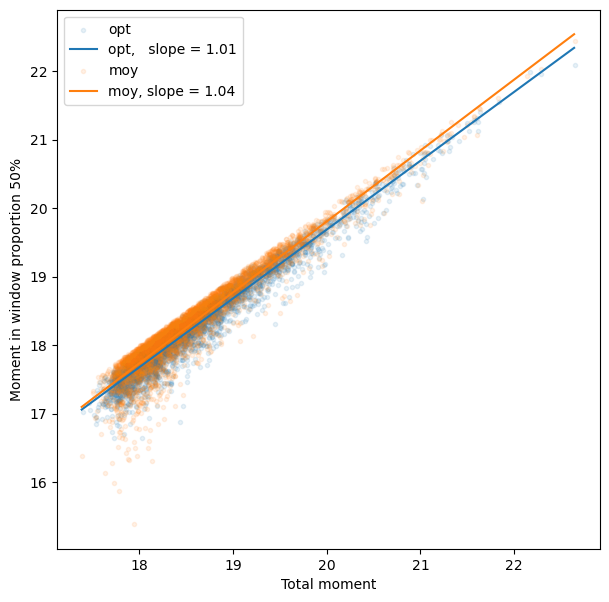

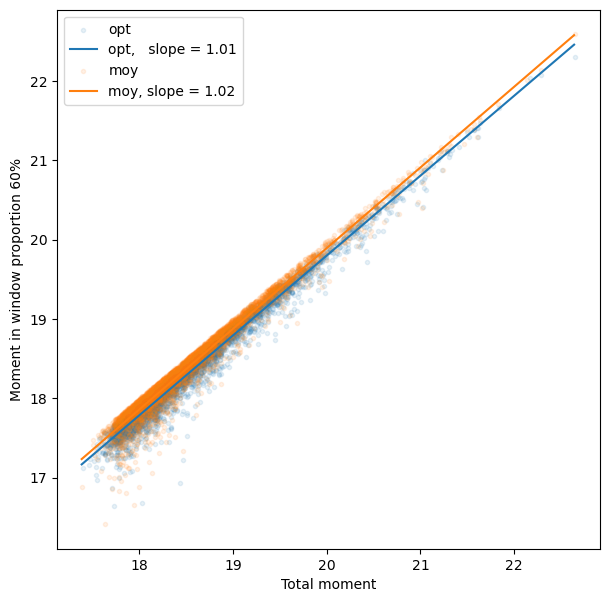

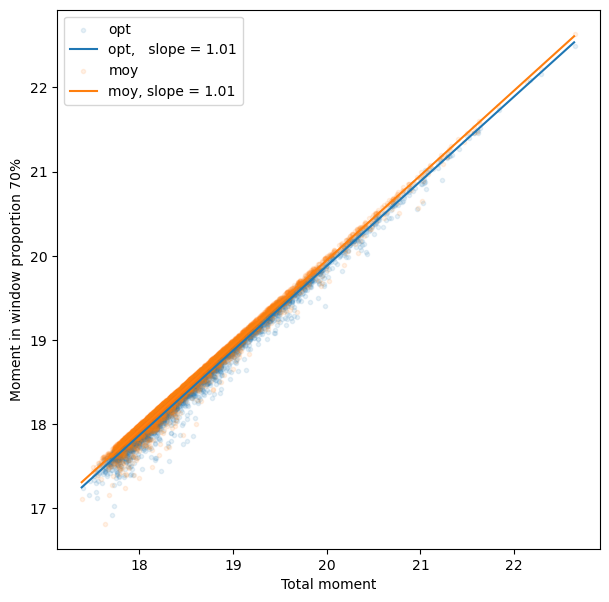

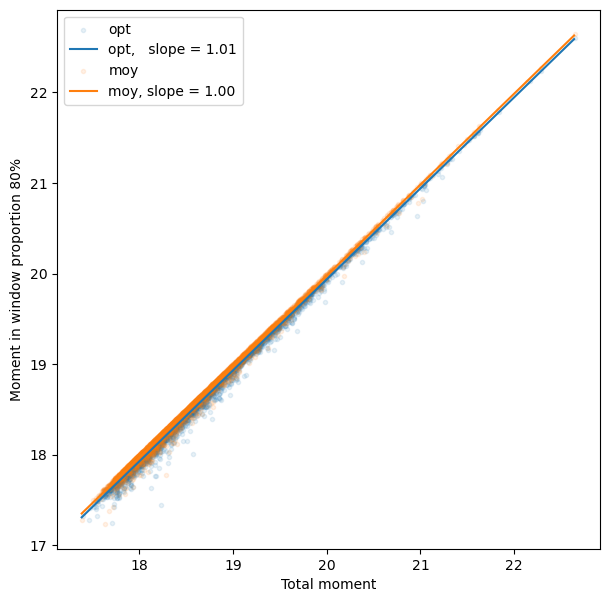

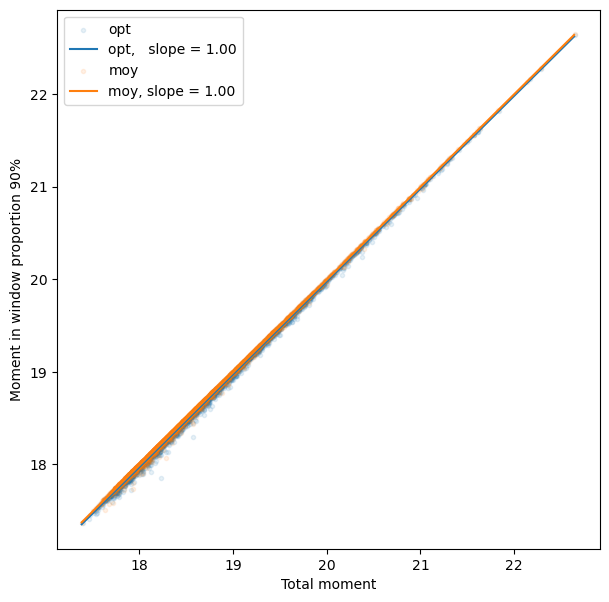

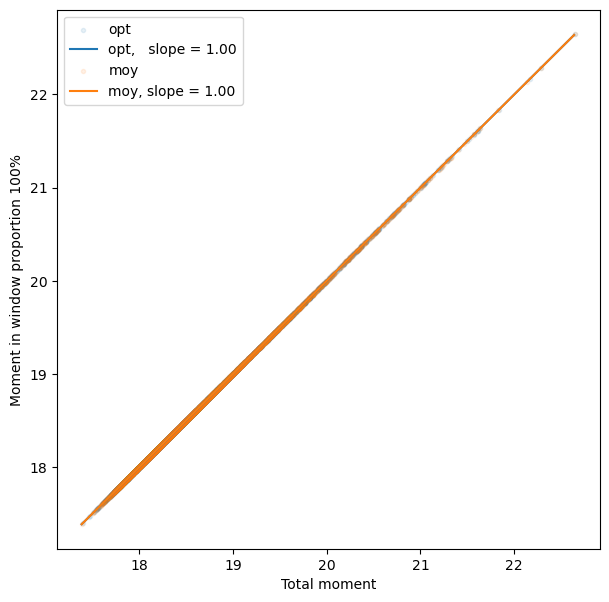

In [73]:
interval = 0.1

for window_prop in np.arange(0.1, 1.1, interval):
    fig, ax = plt.subplots(figsize=(7, 7))
    print(window_prop)
    moments, simpson, simpson_short, trapz, durations = moment_in_different_windows(window_prop = window_prop)
    moments_moy, simpson_moy, simpson_short_moy, trapz_moy, durations_moy = moment_in_different_windows_moy(window_prop = window_prop)

    durations = np.array(durations)
    moments = np.array(moments)
    simpson = np.array(simpson)
    simpson_short = np.array(simpson_short)

    durations_moy = np.array(durations_moy)
    moments_moy = np.array(moments_moy)
    simpson_moy = np.array(simpson_moy)
    simpson_short_moy = np.array(simpson_short_moy)

    ax.scatter(np.log10(simpson), np.log10(simpson_short), label = 'opt', alpha = 0.1, marker = '.')#, color = cmc.lajolla(window_prop), alpha = 0.1)#, vmax=60)
    not_zero = np.where(simpson_short > 0)[0]

    result = scipy.stats.linregress(np.log10(simpson[not_zero]), np.log10(simpson_short[not_zero]))

    x_plot = np.log10(np.logspace(np.log10(min(moments)), np.log10(max(moments))))

    ax.plot(x_plot, result.intercept + x_plot*result.slope,
            label = f'opt,   slope = {result.slope:.2f}',
            alpha = 1,
            color = 'tab:blue')

    ax.scatter(np.log10(simpson_moy), np.log10(simpson_short_moy), label = 'moy', alpha = 0.1, marker = '.')#, color = cmc.lajolla(window_prop), alpha = 0.1)#, vmax
    not_zero = np.where(simpson_short_moy > 0)[0]

    result = scipy.stats.linregress(np.log10(simpson_moy[not_zero]), np.log10(simpson_short_moy[not_zero]))

    x_plot_moy = np.log10(np.logspace(np.log10(min(moments_moy)), np.log10(max(moments_moy))))

    ax.plot(x_plot, result.intercept + x_plot*result.slope,
            label = f'moy, slope = {result.slope:.2f}',
            alpha = 1,
            color = 'tab:orange')

    # plt.xscale('log')
    # plt.yscale('log')

    plt.ylabel(f'Moment in window proportion {window_prop*100:.0f}%')
    plt.xlabel('Total moment')

    plt.legend()
    fig.show()

    fig.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/integrating_in_window/linregress_compare_moy_and_opt_window_prop_{window_prop}.png')

In [75]:
#find last consequetive zero value